In [1]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
from pprint import pprint
import calendar

from Common_Module.Common_InterestRate import get_interest_data
from Common_Module.Common_Stockdata import get_stock_data

## CREATING A REQUESTS
Using Common Modules and FREDAPI aquire the monthly Interest Rates and Profits over 10 years (2010-2019)

For this segment, we will make our request to the FRED API and AlphaAdvantage API for data in the form of a json and dataframe respectively, please
ensure you have edited the api_keys.py file to have your unique keys


In [2]:
# Request stock dataframe from Common_Stockdata.py
stock_info_df = get_stock_data()

# Fred API Dataframe
interest_data = get_interest_data()

## Assemble the Dataframes ready for merging
In this segment we will take our raw data from our requests and sort it into monthly data ready to be all merged together into a complete frame

In [3]:
## Using Common_Stockdata.py to make a new dataframe for Monthly Profits
# Date, Month Column creation by using Date
stock_info_df['Year'] = stock_info_df['Date'].dt.year
stock_info_df['Month_Number'] = stock_info_df['Date'].dt.month

# Close price for each Year, Month
monthly_data = stock_info_df.groupby(['Year', 'Month_Number'])
last_close = monthly_data['Close'].last().reset_index()
first_open = monthly_data["Open"].first().reset_index()
profit_monthly = last_close['Close'] - first_open['Open']
profit_df = pd.DataFrame({'profit_monthly': profit_monthly})

# dataFrame creation
monthly_profit_df = pd.DataFrame({
                                    'Year': last_close['Year'],
                                    'Month_Number': last_close['Month_Number'],
                                    'Monthly_Profit': profit_df['profit_monthly']
                                })

# Generate month numbers (1-12)
month_numbers = list(range(1, 13))

# Use list comprehension to map month numbers to month names
month_names = [calendar.month_name[month] for month in month_numbers]

# Create the DataFrame
month_df = pd.DataFrame({
                            'Month_Number': month_numbers,
                            'Month': month_names
                        })

# Merge the DataFrames on 'Month' from monthly_profit_df and 'Month Number' from month_df
monthly_profit_merge_df = pd.merge(monthly_profit_df, month_df, left_on='Month_Number', right_on='Month_Number', how='left')
monthly_profit_final_df = monthly_profit_merge_df[["Year", "Month", "Monthly_Profit"]]

In [4]:
# Merging the Fred frame with Month names
merged_interest_df = pd.merge(interest_data, month_df, left_on="Month",right_on="Month_Number", how="left")
same_merged_interest_df = merged_interest_df[['Year', "Month_y", "Interest_Rate"]]
same_merged_interest_df.loc[:, "Year"] = same_merged_interest_df["Year"].astype(float)

In [5]:
# Creating a new merged dataframe of the two separate ones
same_month_df = pd.merge(same_merged_interest_df, monthly_profit_final_df, left_on=["Year", "Month_y"], right_on=["Year", "Month"], how="left")
same_month_df = same_month_df[["Year", "Month", "Interest_Rate", "Monthly_Profit"]]

## Creating the Scatter
Now that we have all of our data and its neatly organised, we can create a scatterplot for:

1. Monthly Profits compared to the interest rates one month after that month

In [6]:
# Shifting the month column down one to be aligned with next months rates (eg the profits of Feb compared with Interest rates of March)
same_month_df[["Month_After", "Interest_After"]] = same_month_df[["Month", 'Interest_Rate']].shift(-1)
monthafter_df = same_month_df[["Year", "Month_After", "Interest_After", "Monthly_Profit"]]
month_after_df = monthafter_df.drop(monthafter_df.index[-1])

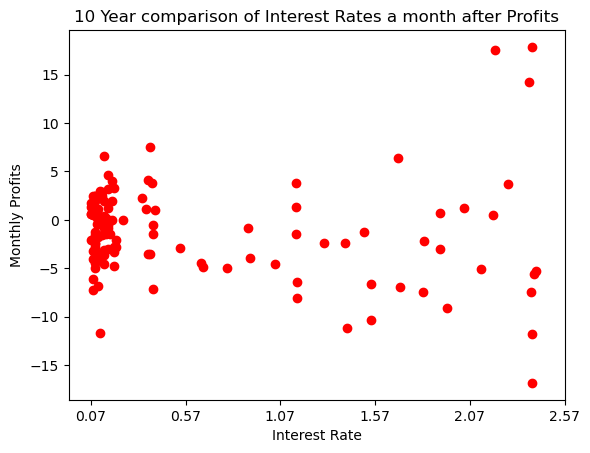

In [7]:
ma_int_rate = month_after_df["Interest_After"].tolist()
ma_month_prof = month_after_df["Monthly_Profit"].tolist()

ma_int_rate_float = [float(val) for val in ma_int_rate]
ma_month_prof_float = [float(val) for val in ma_month_prof]

plt.scatter(ma_int_rate_float, ma_month_prof_float, color='red', label="Dataset1")
plt.xticks(np.arange(min(ma_int_rate_float), max(ma_int_rate_float)+0.5, 0.5))
plt.xlabel('Interest Rate')
plt.ylabel('Monthly Profits')
plt.title('10 Year comparison of Interest Rates a month after Profits')
plt.savefig("output_data/InterestGraph1.png")